[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/xiptos/is_notes/blob/main/lstm.ipynb)

# Text Classification using LSTM

## Import libraries

First, it is necessary to import the required libraries.

In [22]:
import pandas as pd
from collections import Counter
from functools import partial
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm
from torchtext.data.utils import get_tokenizer
from nltk.corpus import stopwords
from torch import nn, optim
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import torch
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data.dataset import random_split

tqdm.pandas()

## Download the dataset and select a subset of it

The dataset is big, composed of more than 4 million records. Let's download it and process it to retrieve a smaller sample.

In [95]:
df = pd.read_csv('https://files.consumerfinance.gov/ccdb/complaints.csv.zip', dtype='str')

Remove all the records that have wither empty label (`Product`) or content (`Consumer complaint narrative`)

In [96]:
print(df.shape)
df_nonan = df[df['Consumer complaint narrative'].notna() & df['Product'].notna()]
print(df_nonan.shape)

(4375202, 18)
(1590094, 18)


Select 100000 random samples

In [97]:
sample = df_nonan.sample(n=100000, ignore_index=True)
sample = sample[["Product", "Consumer complaint narrative"]]
print(sample.shape)

Check the full set of labels

In [99]:
sample.Product.value_counts()

Product
Credit reporting, credit repair services, or other personal consumer reports    50708
Debt collection                                                                 14286
Mortgage                                                                         6998
Credit card or prepaid card                                                      6750
Checking or savings account                                                      5147
Credit reporting or other personal consumer reports                              3225
Student loan                                                                     2343
Money transfer, virtual currency, or money service                               2225
Credit reporting                                                                 2056
Vehicle loan or lease                                                            1742
Credit card                                                                      1497
Payday loan, title loan, or personal loan     

## Consolidate labels

There are some categories (labels) that have simillar meaning or context. Let's unify them, thus reducing the number of classes.

In [100]:
sample.loc[sample[
               'Product'] == 'Credit reporting', 'Product'] = 'Credit reporting, credit repair services, or other personal consumer reports'
sample.loc[sample[
               'Product'] == 'Credit reporting or other personal consumer reports', 'Product'] = 'Credit reporting, credit repair services, or other personal consumer reports'
sample.loc[sample['Product'] == 'Credit card', 'Product'] = 'Credit card or prepaid card'
sample.loc[sample['Product'] == 'Prepaid card', 'Product'] = 'Credit card or prepaid card'
sample.loc[sample['Product'] == 'Payday loan', 'Product'] = 'Payday loan, title loan, or personal loan'
sample.loc[sample['Product'] == 'Vehicle loan or lease', 'Product'] = 'Payday loan, title loan, or personal loan'
sample.loc[sample['Product'] == 'Virtual currency', 'Product'] = 'Money transfer, virtual currency, or money service'
sample = sample[sample.Product != 'Other financial service']

In [101]:
sample.Product.value_counts()

Product
Credit reporting, credit repair services, or other personal consumer reports    55989
Debt collection                                                                 14286
Credit card or prepaid card                                                      8371
Mortgage                                                                         6998
Checking or savings account                                                      5147
Payday loan, title loan, or personal loan                                        2900
Student loan                                                                     2343
Money transfer, virtual currency, or money service                               2226
Bank account or service                                                           988
Consumer Loan                                                                     592
Money transfers                                                                    87
Payday loan, title loan, personal loan, or adv

<Axes: title={'center': 'Number complaints in each product'}, xlabel='Product'>

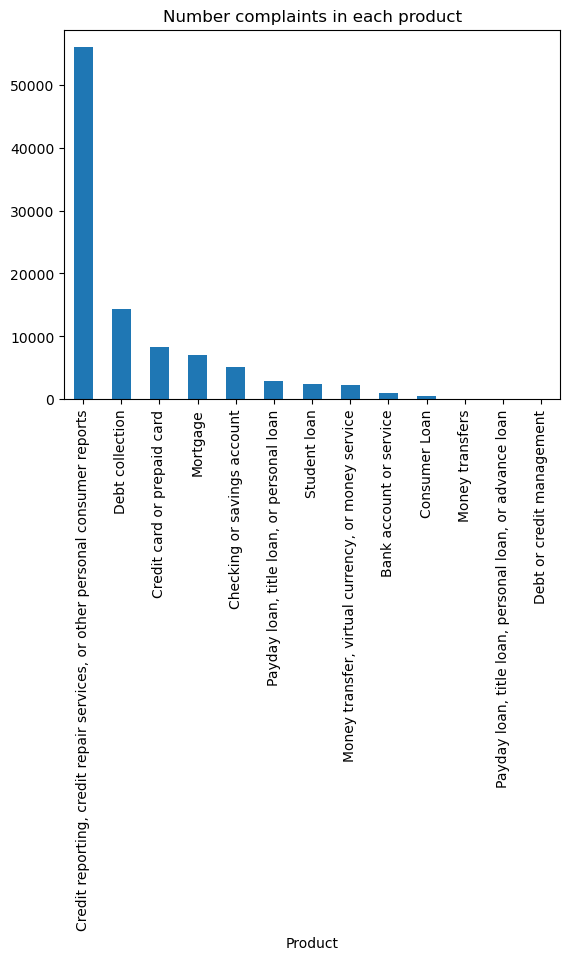

In [102]:
sample['Product'].value_counts().sort_values(ascending=False).plot(kind='bar',
                                                                   title='Number complaints in each product')

## Save the current dataset

So that we don't need to do the same process again... we can start from the **Text Processing** section, after this.

In [2]:
sample.to_pickle("sample.pkl")

NameError: name 'sample' is not defined

# Text Preprocessing

Let's start by reading the dataset sample, saved previously.

In [23]:
sample = pd.read_pickle("sample.pkl")

As an example, let's print two records.

In [24]:
def print_plot(index):
    example = sample[sample.index == index][['Consumer complaint narrative', 'Product']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Product:', example[1])


print_plot(10)
print("-----------")
print_plot(88)

Tower loan has run my credit several times and i have not tried to take out a loan or given them permission in any way to run my credit. I reached out to them and they have denied running my credit.
Product: Credit reporting, credit repair services, or other personal consumer reports
-----------
They call 5 times a day and do not leave messages and when the phone is answered the do not say anything. This happens everyday for the past year or two.
Product: Debt collection


Replace the text label for a number, so that we have a numeric representation of the classes.

In [25]:
sample.Product = pd.Categorical(sample.Product)
codes, unique = pd.factorize(sample.Product)
sample.Product = codes
sample

,Product,Consumer complaint narrative
0,0,"I previously filed a complaint on XX/XX/2018, ..."
1,0,I already submitted similar complement before....
2,1,Welcome bonus terms -- 1 purchase by XX/XX/21 ...
3,2,There has been an issue with my identity being...
4,3,Mortgage company called county tax office on X...
...,...,...
99995,2,"To whom it may concern, I submitted a requeste..."
99996,4,Hi I paid this debt off over a year ago and th...
99997,4,XXXX XXXX XXXX has been harassing me about pay...
99998,2,TRANSUNION has permitted the collection agency...


# LSTM Model

Now we can start working towards the design and development of an LSTM model for classification.

Let's start by creating the `Dataset` class able to interpret, clean and convert the text.

In [32]:
import re
import nltk
from nltk import WordNetLemmatizer
!pip install -U pywsd
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
sample = sample.reset_index(drop=True)
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()


def clean_text(text):
    # lowercase text
    text = text.lower()
    # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = REPLACE_BY_SPACE_RE.sub(' ', text)
    # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing.
    text = BAD_SYMBOLS_RE.sub('', text)
    text = text.replace('x', '')
    new_sent = ''
    for word in text.split():
        # Remove stop words
        if word not in STOPWORDS:
            # Lemmatize
            word = lemmatizer.lemmatize(word)
            new_sent = new_sent + ' ' + word
    text = new_sent
    return text


def remove_rare_words(tokens, common_tokens, max_len):
    return [token if token in common_tokens
            else '<unk>' for token in tokens][-max_len:]


def tokenize(text, stop_words):
    tokenizer = get_tokenizer("basic_english")
    tokens = tokenizer(text)
    tokens = [token for token in tokens if token not in stop_words]
    return tokens


class DataFrameTextDataset(Dataset):
    def __init__(self, text: list, label: list, max_vocab, max_len):
        df = pd.DataFrame(list(zip(text, label)), columns=['text', 'label'])

        # Clean and tokenize
        stop_words = set(stopwords.words('english'))
        df.text = df.text.progress_apply(clean_text)
        df.text = df.text.str.replace('\d+', '')
        df['tokens'] = df.text.progress_apply(partial(tokenize, stop_words=stop_words))

        # Replace rare words with <unk>
        all_tokens = [sublst for lst in df.tokens.tolist() for sublst in lst]
        common_tokens = set(list(zip(*Counter(all_tokens).most_common(max_vocab)))[0])
        df.loc[:, 'tokens'] = df.tokens.progress_apply(
            partial(remove_rare_words, common_tokens=common_tokens, max_len=max_len))

        # Remove sequences with only <UNK>
        df = df[df.tokens.progress_apply(lambda tokens: any(token != '<unk>' for token in tokens))]

        vocab = sorted({sublst for lst in df.tokens.tolist() for sublst in lst})
        self.token2idx = {token: idx for idx, token in enumerate(vocab)}

        # Add a padding idx
        self.token2idx['<pad>'] = max(self.token2idx.values()) + 1

        self.idx2token = {idx: token for token, idx in self.token2idx.items()}

        df.loc[:, 'indexed_tokens'] = df.loc[:, 'tokens'].apply(
            lambda tokens: [self.token2idx[token] for token in tokens])
        self.text = df.text.tolist()
        self.sequences = df.indexed_tokens.tolist()
        self.targets = df.label.tolist()

    def __getitem__(self, i):
        return self.sequences[i], self.targets[i], self.text[i]

    def __len__(self):
        return len(self.sequences)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/rlopes/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /Users/rlopes/nltk_data...


In [33]:
# How many of the most common vocab words to keep
# Uncommon words get replaced with unknown token <unk>
max_vocab = 1000

# How many tokens long each sequence will be cut to
# Shorter sequences will get the padding token <pad>
max_len = 220

dataset = DataFrameTextDataset(sample['Consumer complaint narrative'].tolist(), sample['Product'].tolist(), max_vocab,
                               max_len)

  0%|          | 0/99974 [00:00<?, ?it/s]

  0%|          | 0/99974 [00:00<?, ?it/s]

  0%|          | 0/99974 [00:00<?, ?it/s]

  0%|          | 0/99974 [00:00<?, ?it/s]

Check the vocabulary...

In [53]:
dataset.token2idx

{'#': 0,
 '000': 1,
 '1': 2,
 '10': 3,
 '100': 4,
 '10000': 5,
 '100000': 6,
 '12': 7,
 '15': 8,
 '1681': 9,
 '1681b': 10,
 '1681c': 11,
 '1681i': 12,
 '1681s2': 13,
 '18': 14,
 '2': 15,
 '20': 16,
 '20000': 17,
 '2015': 18,
 '2016': 19,
 '2017': 20,
 '2018': 21,
 '2019': 22,
 '2020': 23,
 '2021': 24,
 '2022': 25,
 '2023': 26,
 '21': 27,
 '3': 28,
 '30': 29,
 '3rd': 30,
 '4': 31,
 '5': 32,
 '50000': 33,
 '6': 34,
 '60': 35,
 '602': 36,
 '604': 37,
 '605b': 38,
 '609': 39,
 '611': 40,
 '623': 41,
 '7': 42,
 '8': 43,
 '90': 44,
 '<unk>': 45,
 'ability': 46,
 'able': 47,
 'accept': 48,
 'accepted': 49,
 'access': 50,
 'accordance': 51,
 'according': 52,
 'account': 53,
 'acct': 54,
 'accuracy': 55,
 'accurate': 56,
 'act': 57,
 'action': 58,
 'active': 59,
 'activity': 60,
 'actual': 61,
 'actually': 62,
 'add': 63,
 'added': 64,
 'addition': 65,
 'additional': 66,
 'additionally': 67,
 'address': 68,
 'advantage': 69,
 'adverse': 70,
 'advised': 71,
 'affected': 72,
 'affecting': 73,
 'a

Split dataset into train, validation, and test

In [54]:
def split_train_valid_test(corpus, valid_ratio=0.1, test_ratio=0.1):
    test_length = int(len(corpus) * test_ratio)
    valid_length = int(len(corpus) * valid_ratio)
    train_length = len(corpus) - valid_length - test_length
    return random_split(corpus, lengths=[train_length, valid_length, test_length])

In [55]:
valid_ratio = 0.05
test_ratio = 0.05

train_dataset, valid_dataset, test_dataset = split_train_valid_test(dataset, valid_ratio=valid_ratio, test_ratio=test_ratio)
len(train_dataset), len(valid_dataset), len(test_dataset)

(89949, 4997, 4997)

Create the `DataLoader`s

In [37]:
def collate(batch):
    inputs = [item[0] for item in batch]
    target = torch.LongTensor([item[1] for item in batch])
    text = [item[2] for item in batch]
    return inputs, target, text


batch_size = 512

train_loader = DataLoader(train_dataset, batch_size=batch_size, collate_fn=collate)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, collate_fn=collate)
test_loader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=collate)

## Create the Model

In [56]:
def pad_sequences(sequences, padding_val=0, pad_left=False):
    """Pad a list of sequences to the same length with a padding_val."""
    sequence_length = max(len(sequence) for sequence in sequences)
    if not pad_left:
        return [sequence + (sequence_length - len(sequence)) * [padding_val] for sequence in sequences]
    return [(sequence_length - len(sequence)) * [padding_val] + sequence for sequence in sequences]


class TextClassificationModel(nn.Module):
    def __init__(self, output_size, hidden_size, vocab_size, padding_idx,
                 device, dropout_probability=0.3, bidirectional=False, n_layers=1,
                 embedding_dimension=50, batch_size=32):
        super(TextClassificationModel, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.batch_size = batch_size
        self.n_layers = n_layers
        self.dropout_probability = dropout_probability
        self.device = device
        self.padding_idx = padding_idx

        # We need to multiply some layers by two if the model is bidirectional
        self.input_size_factor = 2 if bidirectional else 1

        self.embedding = nn.Embedding(vocab_size, embedding_dimension)

        self.rnn = nn.LSTM(embedding_dimension, self.hidden_size, self.n_layers, bidirectional=bidirectional)
        self.drop = nn.Dropout(p=self.dropout_probability)
        self.fc1 = nn.Linear(self.hidden_size * self.input_size_factor, 16)
        self.fc2 = nn.Linear(16, self.output_size)

    def init_hidden(self):
        """Set initial hidden states."""
        h0 = torch.randn(self.n_layers * self.input_size_factor, self.batch_size, self.hidden_size)
        c0 = torch.randn(self.n_layers * self.input_size_factor, self.batch_size, self.hidden_size)
        h0 = h0.to(self.device)
        c0 = c0.to(self.device)
        return h0, c0

    def apply_rnn(self, embedding_out, lengths):
        packed = pack_padded_sequence(embedding_out, lengths, batch_first=True)
        activations, _ = self.rnn(packed, self.init_hidden())
        activations, _ = pad_packed_sequence(activations, batch_first=True)

        indices = (lengths - 1).view(-1, 1).expand(activations.size(0), activations.size(2), ).unsqueeze(1)
        indices = indices.to(self.device)

        activations = activations.gather(1, indices).squeeze(1)
        return activations

    def forward(self, inputs, return_activations=False):
        batch_size = len(inputs)

        # This makes the model not break for the last batch that might be less
        # than batch_size in size
        if batch_size != self.batch_size:
            self.batch_size = batch_size

        lengths = torch.LongTensor([len(x) for x in inputs])
        lengths, permutation_indices = lengths.sort(0, descending=True)

        # Pad sequences so that they are all the same length
        padded_inputs = pad_sequences(inputs, padding_val=self.padding_idx)
        inputs = torch.LongTensor(padded_inputs)

        # Sort inputs
        inputs = inputs[permutation_indices].to(self.device)
        # Get embeddings
        embedding_out = self.embedding(inputs)

        activations = self.apply_rnn(embedding_out, lengths)

        x = self.drop(torch.relu(self.fc1(activations)))
        x = self.fc2(x)
        out = torch.sigmoid(x)

        # Put the output back in correct order
        permutation_index_pairs = list(zip(permutation_indices.tolist(), list(range(len(permutation_indices)))))
        reordered_indices = [pair[1] for pair in sorted(permutation_index_pairs, key=lambda pair: pair[0])]

        if return_activations:
            return out[reordered_indices], x[reordered_indices]

        return out[reordered_indices]

Create the functions for training and validating.

In [38]:
def train_epoch(model, optimizer, scheduler, train_loader):
    model.train()
    total_loss = total = 0
    progress_bar = tqdm(train_loader, desc='Training', leave=False)
    for inputs, target, text in progress_bar:
        target = target.to(device)
        # Clean old gradients
        optimizer.zero_grad()
        # Forwards pass
        output = model(inputs)
        # Calculate how wrong the model is
        loss = criterion(output, target)
        # Perform gradient descent, backwards pass
        loss.backward()
        # Take a step in the right direction
        optimizer.step()
        scheduler.step()
        # Record metrics
        total_loss += loss.item()
        total += len(target)

    return total_loss / total


def validate_epoch(model, valid_loader):
    model.eval()
    total_loss = total = 0
    with torch.no_grad():
        progress_bar = tqdm(valid_loader, desc='Validating', leave=False)
        for inputs, target, text in progress_bar:
            target = target.to(device)
            # Forwards pass
            output = model(inputs)
            # Calculate how wrong the model is
            loss = criterion(output, target)
            # Record metrics
            total_loss += loss.item()
            total += len(target)

    return total_loss / total

## Finally, train the model

In [40]:
if torch.cuda.is_available():
    device = torch.device('cuda')
# elif torch.backends.mps.is_available():
#     device = torch.device('mps')
else:
    device = torch.device('cpu')
device

device(type='cpu')

In [41]:
dropout_probability = 0.2
n_rnn_layers = 1
embedding_dimension = 128
hidden_size = 64
is_bidirectional = True
max_epochs = 10
learning_rate = 0.001

model = TextClassificationModel(
    output_size=13,
    hidden_size=hidden_size,
    embedding_dimension=embedding_dimension,
    vocab_size=len(dataset.token2idx),
    padding_idx=dataset.token2idx['<pad>'],
    dropout_probability=dropout_probability,
    bidirectional=is_bidirectional,
    n_layers=n_rnn_layers,
    device=device,
    batch_size=batch_size
)
model = model.to(device)
model

TextClassificationModel(
  (embedding): Embedding(1002, 128)
  (rnn): LSTM(128, 64, bidirectional=True)
  (drop): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=128, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=13, bias=True)
)

In [43]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate)
scheduler = CosineAnnealingLR(optimizer, 1)

In [44]:
n_epochs = 0
train_losses, valid_losses = [], []
for _ in range(max_epochs):
    train_loss = train_epoch(model, optimizer, scheduler, train_loader)
    valid_loss = validate_epoch(model, valid_loader)

    tqdm.write(f'epoch #{n_epochs + 1:3d}\ttrain_loss: {train_loss:.2e}' f'\tvalid_loss: {valid_loss:.2e}\n')

    # Early stopping if the current valid_loss is greater than the last three valid losses
    if len(valid_losses) > 2 and all(valid_loss >= loss for loss in valid_losses[-3:]):
        print('Stopping early')
        break

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    n_epochs += 1

Training:   0%|          | 0/176 [00:00<?, ?it/s]

Validating:   0%|          | 0/10 [00:00<?, ?it/s]

epoch #  1	train_loss: 4.40e-03	valid_loss: 4.21e-03


Training:   0%|          | 0/176 [00:00<?, ?it/s]

Validating:   0%|          | 0/10 [00:00<?, ?it/s]

epoch #  2	train_loss: 4.11e-03	valid_loss: 4.18e-03


Training:   0%|          | 0/176 [00:00<?, ?it/s]

Validating:   0%|          | 0/10 [00:00<?, ?it/s]

epoch #  3	train_loss: 4.08e-03	valid_loss: 4.15e-03


Training:   0%|          | 0/176 [00:00<?, ?it/s]

Validating:   0%|          | 0/10 [00:00<?, ?it/s]

epoch #  4	train_loss: 4.05e-03	valid_loss: 4.12e-03


Training:   0%|          | 0/176 [00:00<?, ?it/s]

Validating:   0%|          | 0/10 [00:00<?, ?it/s]

epoch #  5	train_loss: 4.02e-03	valid_loss: 4.06e-03


Training:   0%|          | 0/176 [00:00<?, ?it/s]

Validating:   0%|          | 0/10 [00:00<?, ?it/s]

epoch #  6	train_loss: 3.96e-03	valid_loss: 3.99e-03


Training:   0%|          | 0/176 [00:00<?, ?it/s]

Validating:   0%|          | 0/10 [00:00<?, ?it/s]

epoch #  7	train_loss: 3.90e-03	valid_loss: 3.96e-03


Training:   0%|          | 0/176 [00:00<?, ?it/s]

Validating:   0%|          | 0/10 [00:00<?, ?it/s]

epoch #  8	train_loss: 3.88e-03	valid_loss: 3.95e-03


Training:   0%|          | 0/176 [00:00<?, ?it/s]

Validating:   0%|          | 0/10 [00:00<?, ?it/s]

epoch #  9	train_loss: 3.86e-03	valid_loss: 3.93e-03


Training:   0%|          | 0/176 [00:00<?, ?it/s]

Validating:   0%|          | 0/10 [00:00<?, ?it/s]

epoch # 10	train_loss: 3.85e-03	valid_loss: 3.94e-03


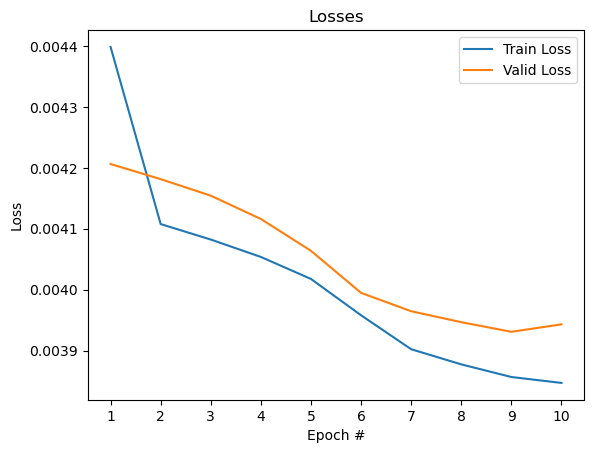

In [45]:
from matplotlib import pyplot as plt

epoch_ticks = range(1, n_epochs + 1)
plt.plot(epoch_ticks, train_losses)
plt.plot(epoch_ticks, valid_losses)
plt.legend(['Train Loss', 'Valid Loss'])
plt.title('Losses')
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.xticks(epoch_ticks)
plt.show()

In [17]:
torch.save(model.state_dict(), "lstm_model.pth")

In [57]:
model = TextClassificationModel(
    output_size=13,  # two classes: positive vs. negative
    hidden_size=hidden_size,
    embedding_dimension=embedding_dimension,
    vocab_size=len(dataset.token2idx),
    padding_idx=dataset.token2idx['<pad>'],
    dropout_probability=dropout_probability,
    bidirectional=is_bidirectional,
    n_layers=n_rnn_layers,
    device=device,
    batch_size=batch_size,
)
model.load_state_dict(torch.load("lstm_model.pth"))
model.eval()

TextClassificationModel(
  (embedding): Embedding(1002, 128)
  (rnn): LSTM(128, 64, bidirectional=True)
  (drop): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=128, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=13, bias=True)
)

In [58]:
from sklearn.metrics import classification_report
import numpy as np

model.eval()
test_accuracy = n_examples = 0
y_true, y_pred = [], []
with torch.no_grad():
    for inputs, target, text in tqdm(test_loader, leave=False):
        target = target.to(device)

        _, logits = model(inputs, return_activations=True)

        logits = logits.detach().cpu().numpy()
        predictions = np.argmax(logits, axis=1)
        target = target.cpu().numpy()

        y_true.extend(predictions)
        y_pred.extend(target)

print(classification_report(y_true, y_pred))

  0%|          | 0/10 [00:00<?, ?it/s]

tensor([[ 366,  266,  773,  ...,  915,   45,  842],
        [ 180,  822,  774,  ...,  783,   45,   45],
        [  45,  723,  143,  ...,  463,   47,  953],
        ...,
        [ 815,  529,  821,  ..., 1001, 1001, 1001],
        [ 343,   45,  517,  ..., 1001, 1001, 1001],
        [ 966,  966, 1001,  ..., 1001, 1001, 1001]])
tensor([[[ 0.9660,  0.2466, -0.5464,  ..., -1.4728, -0.0170, -0.1870],
         [-0.5151, -0.5731, -0.4868,  ...,  1.2267,  0.0449,  0.1171],
         [-0.0696,  1.0108, -0.7915,  ...,  0.3471, -0.2649, -0.6014],
         ...,
         [ 1.9378, -0.2163, -1.3722,  ...,  1.6312,  2.3130, -2.3587],
         [ 1.0273, -0.6739, -0.1306,  ..., -0.8637,  0.1240,  0.2537],
         [ 0.7575,  0.6808,  1.0330,  ...,  0.4201,  1.3480, -2.5223]],

        [[-0.7000, -0.8110, -1.0252,  ..., -0.1010,  0.0350,  0.5547],
         [-0.1484,  0.7462,  0.9866,  ..., -0.6239,  0.0903,  0.7766],
         [ 0.3483,  0.1080, -0.5864,  ...,  1.2636, -0.1586, -0.6150],
         ...,
     

/Users/rlopes/miniconda3/envs/is/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rlopes/miniconda3/envs/is/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rlopes/miniconda3/envs/is/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [60]:
import random
from ipywidgets import HTML

flatten = lambda x: [sublst for lst in x for sublst in lst]
inputs_lst, target_lst, text_lst = zip(*test_loader)
inputs_lst, target_lst, text_lst = map(flatten, [inputs_lst, target_lst, text_lst])
test_examples = list(zip(inputs_lst, target_lst, text_lst))


def print_random_prediction(n=10):
    to_emoji = lambda y1, y2: '😄' if y1 == y2 else '😡'
    model.eval()
    rows = []
    for _ in range(n):
        with torch.no_grad():
            inputs, target, text = random.choice(test_examples)
            target = target.item()

            _, logits = model([inputs], return_activations=True)
            logits = logits.detach().cpu().numpy()
            prediction = np.argmax(logits, axis=1)[0]

            predicted = to_emoji(target, prediction)

            row = f"""
            <tr>
            <td>{text}&nbsp;</td>
            <td>{unique[prediction]} == {unique[target]}&nbsp;</td>
            <td>{predicted}&nbsp;</td>
            </tr>
            """
            rows.append(row)

    rows_joined = '\n'.join(rows)
    table = f"""
<table>
<tbody>
<tr>
<td><b>Review</b>&nbsp;</td>
<td><b>Predicted</b>&nbsp;</td>
<td><b>Actual</b>&nbsp;</td>
</tr>
{rows_joined}
</tbody>
</table>
"""
    display(HTML(table))

In [61]:
print_random_prediction(10)

tensor([[ 244,   45,  143,  829,  915,  919,  405,   45,  993,  765,  140,   85,
         1000,  764,   45]])
tensor([[[-0.0908,  0.1099,  0.3184,  ...,  0.0758,  0.9385, -0.7371],
         [ 1.0273, -0.6739, -0.1306,  ..., -0.8637,  0.1240,  0.2537],
         [ 0.9744, -1.1733,  0.2189,  ...,  0.0186,  0.1697, -1.8631],
         ...,
         [ 1.1877,  1.0164,  0.8558,  ...,  1.1655, -0.7784, -0.1015],
         [ 0.4948,  1.0173, -0.9312,  ..., -1.1180,  0.1065, -1.1160],
         [ 1.0273, -0.6739, -0.1306,  ..., -0.8637,  0.1240,  0.2537]]])
tensor([[319, 973, 815, 266, 771, 463,  45, 576,  45, 404]])
tensor([[[-0.2306,  0.9798,  1.8216,  ...,  1.0044,  0.7435,  0.2145],
         [ 0.4222, -1.2051,  0.6399,  ..., -0.3388, -0.2540,  0.3721],
         [ 0.4588, -0.9987, -0.2228,  ..., -0.2245, -0.1353, -1.1859],
         ...,
         [ 0.7227,  0.2920,  0.2990,  ...,  0.6091,  0.3135, -0.6840],
         [ 1.0273, -0.6739, -0.1306,  ..., -0.8637,  0.1240,  0.2537],
         [ 0.1322,

HTML(value='\n<table>\n<tbody>\n<tr>\n<td><b>Review</b>&nbsp;</td>\n<td><b>Predicted</b>&nbsp;</td>\n<td><b>Ac…